In [1]:
from sklearn.datasets.samples_generator import make_blobs
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend
from matplotlib import pyplot

C:\Anaconda3\envs\nlpiaenv\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# monitor the learning rate
class LearningRateMonitor(Callback):
    
    # start of training
    def on_train_begin(self, logs={}):
        self.lrates = list()

    # end of each training epoch
    def on_epoch_end(self, epoch, logs={}):
        # get and store the learning rate
        optimizer = self.model.optimizer
        lrate = float(backend.get_value(optimizer.lr))
        self.lrates.append(lrate)

In [3]:
# prepare train and test dataset
def prepare_data():
    
    # generate 2d classification dataset
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

    # one hot encode output variable
    y = to_categorical(y)
    # split into train and test
    n_train = 500
    trainX, testX = X[:n_train, :], X[n_train:, :]
    trainy, testy = y[:n_train], y[n_train:]
    return trainX, trainy, testX, testy

In [4]:
# fit a model and plot learning curve
def fit_model(trainX, trainy, testX, testy, patience):
    # define model
    model = Sequential()
    model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))

    # compile model
    opt = SGD(lr=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    # fit model
    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience,min_delta=1E-7)
    lrm = LearningRateMonitor()
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200,
                        verbose=0, callbacks=[rlrp, lrm])
    return lrm.lrates, history.history['loss'], history.history['accuracy']

In [5]:
# create line plots for a series
def line_plots(patiences, series):
    for i in range(len(patiences)):
        pyplot.subplot(220 + (i+1))
        pyplot.plot(series[i])
        pyplot.title('patience='+str(patiences[i]), pad=-80)
    pyplot.show()

In [6]:
# prepare dataset
trainX, trainy, testX, testy = prepare_data()

In [7]:
# create learning curves for different patiences
patiences = [2, 5, 10, 15]

In [8]:
lr_list, loss_list, acc_list, = list(), list(), list()

In [9]:
for i in range(len(patiences)):
    # fit model and plot learning curves for a patience
    lr, loss, acc = fit_model(trainX, trainy, testX, testy, patiences[i])
    lr_list.append(lr)
    loss_list.append(loss)
    acc_list.append(acc)

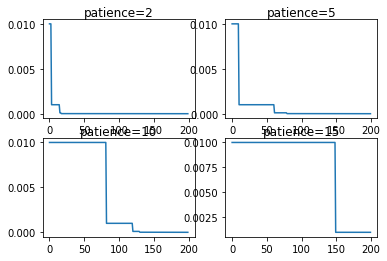

In [10]:
# plot learning rates
line_plots(patiences, lr_list)

In [ ]:
'''The first figure shows line plots of the learning rate over the training epochs for each of the
evaluated patience values. We can see that the smallest patience value of two rapidly drops the
learning rate to a minimum value within 25 epochs, the largest patience of 15 only suffers one
drop in the learning rate. From these plots, we would expect the patience values of 5 and 10 for
this model on this problem to result in better performance as they allow the larger learning rate
to be used for some time before dropping the rate to refine the weights.'''

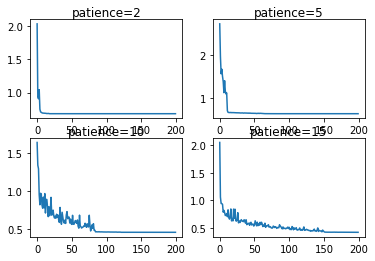

In [11]:
# plot loss
line_plots(patiences, loss_list)

In [ ]:
'''The next figure shows the loss on the training dataset for each of the patience values. The
plot shows that the patience values of 2 and 5 result in a rapid convergence of the model,
perhaps to a sub-optimal loss value. In the case of a patience level of 10 and 15, loss drops
reasonably until the learning rate is dropped below a level that large changes to the loss can be
seen. This occurs halfway for the patience of 10 and nearly the end of the run for patience 15.'''

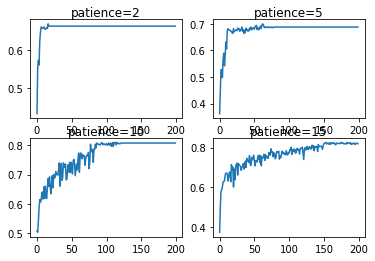

In [12]:
# plot accuracy
line_plots(patiences, acc_list)

In [ ]:
'''The final figure shows the training set accuracy over training epochs for each patience
value. We can see that indeed the small patience values of 2 and 5 epochs results in premature
convergence of the model to a less-than-optimal model at around 65% and less than 75%
accuracy respectively. The larger patience values result in better performing models, with the
patience of 10 showing convergence just before 150 epochs, whereas the patience 15 continues
to show the effects of a volatile accuracy given the nearly completely unchanged learning rate.
These plots show how a learning rate that is decreased a sensible way for the problem and
chosen model configuration can result in both a skillful and converged stable set of final weights,
a desirable property in a final model at the end of a training run.'''